# UMAP Embedding Experiments



In [2]:
# imports 
import os 
import sys
sys.path.append("../")

import numpy as np
# will need additional imports for sklearn/umap/etc

from datahandler import DataHandler

import pandas as pd
import umap
import umap.plot

# Used to get the data
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Some plotting libraries
import matplotlib.pyplot as plt
%matplotlib notebook
from bokeh.plotting import show, save, output_notebook, output_file
from bokeh.resources import INLINE

In [3]:
# set random seed
# seed = np.random.randint(0, 2**32)
seed=123

# supply data directory
data_dir = os.path.join(os.pardir, "data", "preproc")
# load corpus
corpus = DataHandler(data_dir, seed)

# print some various information from the corpus
print("Total Word Count: {}".format(corpus.total_words))
print("Number of Docs in the Corpus: {}".format(corpus.total_docs))

# summarize statistics from all institutions in the corpus
print(corpus.stats)

Total Word Count: 2996921
Number of Docs in the Corpus: 283
[{'inst': 'MIT', 'n_docs': 18, 'wc': 135822}, {'inst': 'Know', 'n_docs': 32, 'wc': 293989}, {'inst': 'GSD', 'n_docs': 37, 'wc': 408691}, {'inst': 'AA', 'n_docs': 137, 'wc': 1532531}, {'inst': 'RISD', 'n_docs': 17, 'wc': 176116}, {'inst': 'CU', 'n_docs': 42, 'wc': 449772}]


## Raw Counts

(283, 46056)
(283, 2)


<IPython.core.display.Javascript object>


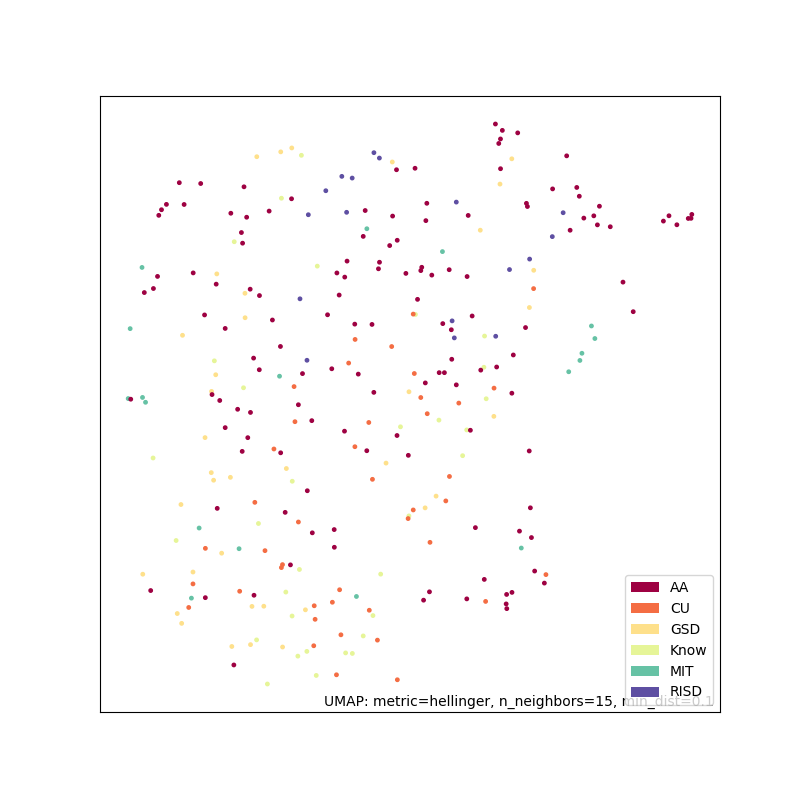

In [4]:
# vectorizer
vectorizer = CountVectorizer(min_df=0, input='filename')
word_doc_matrix = vectorizer.fit_transform(corpus.data.keys())
print(word_doc_matrix.shape)
# print(vectorizer.get_feature_names())
embedding = umap.UMAP(n_components=2, metric='hellinger').fit(word_doc_matrix)
print(embedding.embedding_.shape)
f = umap.plot.points(embedding, labels=np.array(list(corpus.data.values())))

(283, 13806)
(283, 2)


<IPython.core.display.Javascript object>


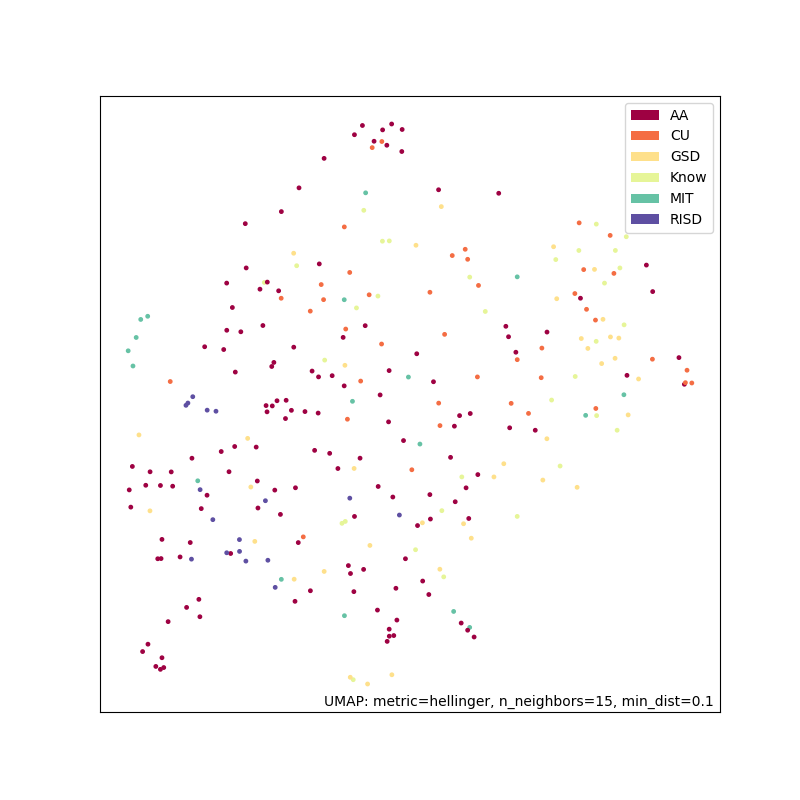

In [5]:
# vectorizer
vectorizer = CountVectorizer(min_df=5, stop_words="english", input='filename')
word_doc_matrix = vectorizer.fit_transform(corpus.data.keys())
print(word_doc_matrix.shape)
# print(vectorizer.get_feature_names())
embedding = umap.UMAP(n_components=2, metric='hellinger').fit(word_doc_matrix)
print(embedding.embedding_.shape)
f = umap.plot.points(embedding, labels=np.array(list(corpus.data.values())))

## TF-IDF 

In [6]:
hover_df = pd.DataFrame(corpus.data.keys(), columns=['inst'])


tfidf_vectorizer = TfidfVectorizer(min_df=5, stop_words='english', input='filename')
tfidf_word_doc_matrix = tfidf_vectorizer.fit_transform(corpus.data.keys())
tfidf_embedding = umap.UMAP(metric='hellinger').fit(tfidf_word_doc_matrix)
fig = umap.plot.interactive(tfidf_embedding, labels=np.array(list(corpus.data.values())),
                            hover_data = hover_df, point_size=10)
show(fig)

Thoughts: tf-idf gives puts lectures from AA into closer to other schools, it isn't clear why
using the speaker as a viz label
maybe the closely related documents are from the same speaker( speaker tours)


<IPython.core.display.Javascript object>


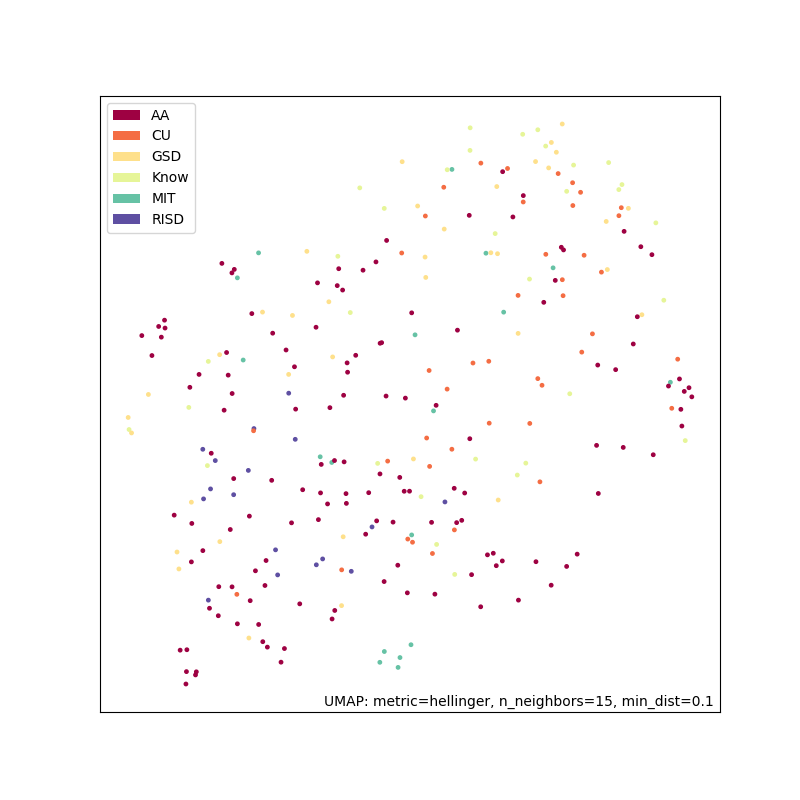

In [7]:
hover_df = pd.DataFrame(corpus.data.keys(), columns=['inst'])


tfidf_vectorizer = TfidfVectorizer(input='filename')
tfidf_word_doc_matrix = tfidf_vectorizer.fit_transform(corpus.data.keys())
tfidf_embedding = umap.UMAP(metric='hellinger').fit(tfidf_word_doc_matrix)
f = umap.plot.points(tfidf_embedding, labels=np.array(list(corpus.data.values())))
fig = umap.plot.interactive(tfidf_embedding, labels=np.array(list(corpus.data.values())),
                            hover_data = hover_df, point_size=10)
show(fig)

difference between professional vs academic lectures. still isn't clear why 
- AA tend to have round table

(283, 13806)
(283, 2)


<IPython.core.display.Javascript object>


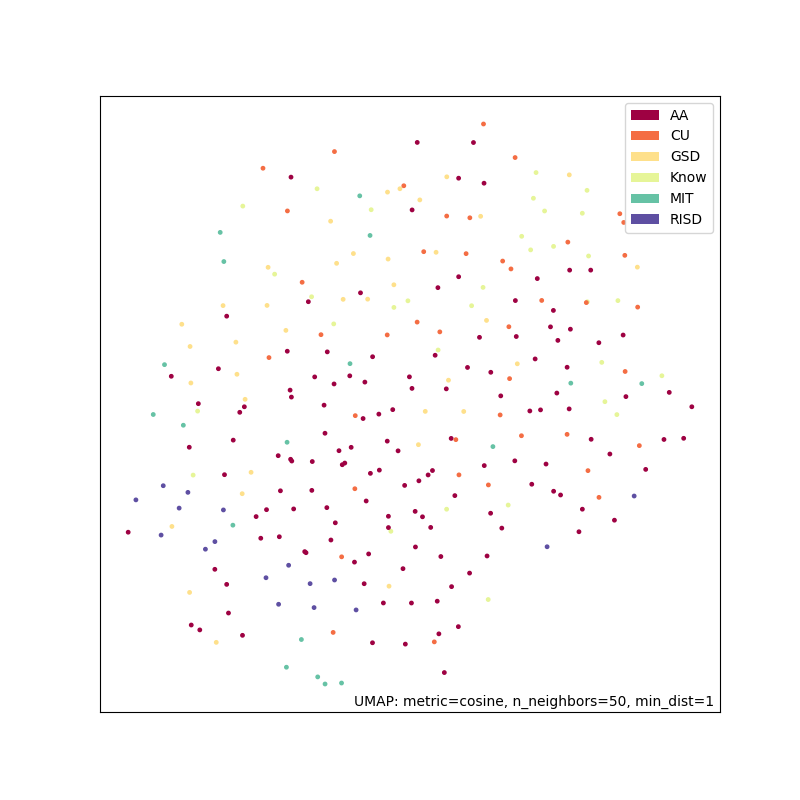

In [8]:
# Experiments with Umap

hover_df = pd.DataFrame(corpus.data.keys(), columns=['inst'])


tfidf_vectorizer = TfidfVectorizer(input='filename', stop_words='english', min_df=5)
tfidf_word_doc_matrix = tfidf_vectorizer.fit_transform(corpus.data.keys())
print(tfidf_word_doc_matrix.shape)
tfidf_embedding = umap.UMAP(n_neighbors=50, metric='cosine', min_dist=1, spread=2.0).fit(tfidf_word_doc_matrix)
print(tfidf_embedding.embedding_.shape)

f = umap.plot.points(tfidf_embedding, labels=np.array(list(corpus.data.values())))
# fig = umap.plot.interactive(tfidf_embedding, labels=np.array(list(corpus.data.values())),
#                             hover_data = hover_df, point_size=10)
# show(fig)

Experimented with cosine embeddings and varied various other umap params, nothing interesting 

(283, 13806)
(283, 2)
(283, 2)


<IPython.core.display.Javascript object>


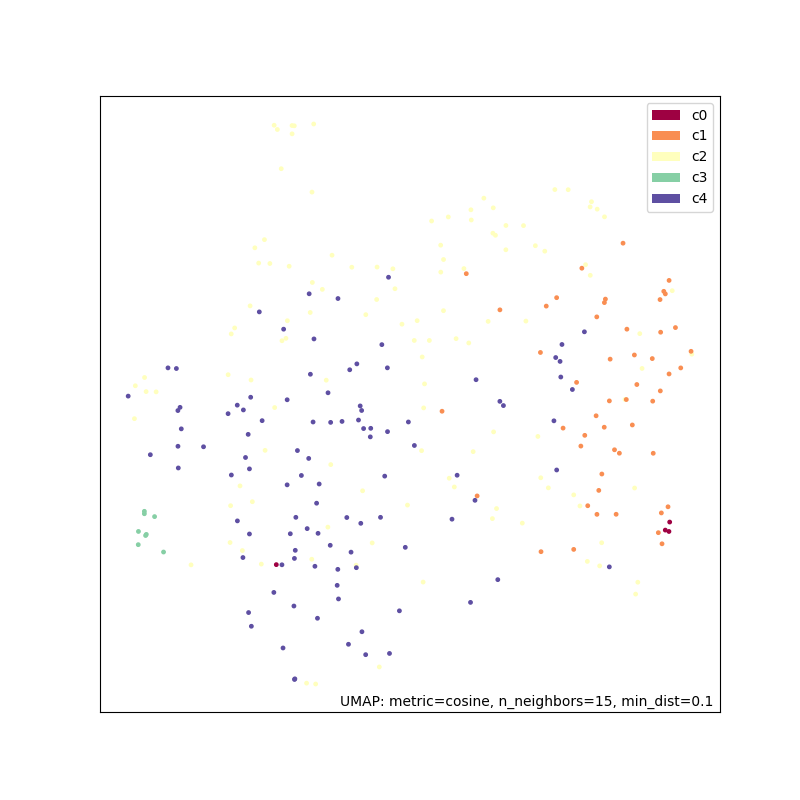

In [87]:
## KMEANS
# learning clusters with kmeans, 
from sklearn.cluster import KMeans

hover_df = pd.DataFrame(corpus.data.keys(), columns=['inst'])


tfidf_vectorizer = TfidfVectorizer(input='filename', stop_words='english', min_df=5)
tfidf_word_doc_matrix = tfidf_vectorizer.fit_transform(corpus.data.keys())
tfidf_embedding = umap.UMAP(n_neighbors=15, metric='cosine', min_dist=.1).fit(tfidf_word_doc_matrix)

clusters = KMeans(n_clusters=5)
clusters.fit(tfidf_word_doc_matrix)

f = umap.plot.points(tfidf_embedding, labels=np.array(["c{}".format(c) for c in clusters.labels_]))


Using labels learned from kmeans, it looks like we have some rough clusters. c3 looks to be a smaller cluster to the left, c0 in the upper right, c4 dominates the top, c2 documents are in the bottom and c1 is all over. Perhaps there is something more here

In [88]:
import csv

labels=np.array([c for c in clusters.labels_])

files = np.array(hover_df).flatten()
names = []
for f in files:
   names.append(os.path.relpath(f, "../data/preproc/"))

x = tfidf_embedding.embedding_[:,0]

y = tfidf_embedding.embedding_[:,1]
    
with open('../results/output.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerows(zip(labels, names, x, y))


From a visual instpection, we have the following
- c3 has \[music\] tags throughout (is this something we may want to remove?)
- for c0, the docuemnts from AA seem to reference tech/geometry/computation, whereas two docs from cooper talk about locations/geography/religion. Not sure what to make of this